In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
!pip install py4j

     |████████████████████████████████| 204kB 3.5MB/s 


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import pandas as pd
data = pd.read_csv('/content/train.csv')

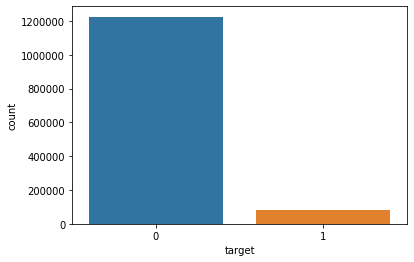

In [72]:
import seaborn as sns
sns.countplot(x='target', data=data)

In [0]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import numpy as np
import gc

In [0]:

def remove_punctuations(text):
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.translate(str.maketrans("","", '1234567890'))
    return text

In [0]:
import string

In [0]:
data['question_text'] = data['question_text'].apply(lambda x: remove_punctuations(x))
test_data=data[1000000:]
data=data[:1000000]
train, test = train_test_split(data, test_size=0.2, random_state=2018)
train_X = train["question_text"].fillna("_na_").values
test_X = test["question_text"].fillna("_na_").values
test_data_X = test_data["question_text"].fillna("_na_").values
test_data_y = test_data["target"].values

In [0]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [0]:
train_X = pad_sequences(train_X, maxlen=70)

In [0]:
test_X = pad_sequences(test_X, maxlen=70)

In [0]:
train_y = train['target'].values
test_y = test['target'].values

In [81]:
train_X.shape

(800000, 70)

In [0]:
train_X=train_X.reshape(-1,70)
test_X=test_X.reshape(-1,70)

In [83]:
train_X.shape

(800000, 70)

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Glove Embedding

In [85]:
EMBEDDING_FILE = '/content/drive/My Drive/ML Project_Quora Insincere Data/ML Project/Embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_1 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_1[i] = embedding_vector

del embeddings_index; gc.collect() 

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

Wiki news

In [86]:
EMBEDDING_FILE = '/content/drive/My Drive/ML Project_Quora Insincere Data/ML Project/Embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_2 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_2[i] = embedding_vector
        
del embeddings_index; gc.collect()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

Paragrams

In [87]:
EMBEDDING_FILE = '/content/drive/My Drive/ML Project_Quora Insincere Data/ML Project/Embeddings/paragram_300_sl999/paragram_300_sl999.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_3 = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= 40000: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_3[i] = embedding_vector

del embeddings_index; gc.collect()   

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


22

Word2Vec

In [88]:
from gensim.models import KeyedVectors

EMBEDDING_FILE = '/content/drive/My Drive/ML Project_Quora Insincere Data/ML Project/Embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'
embeddings_index = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

word_index = tokenizer.word_index
nb_words = min(40000, len(word_index))
embedding_matrix_4 = (np.random.rand(nb_words, embed_size) - 0.5) / 5.0
for word, i in word_index.items():
    if i >= 40000: continue
    if word in embeddings_index:
        embedding_vector = embeddings_index.get_vector(word)
        embedding_matrix_4[i] = embedding_vector
        
del embeddings_index; gc.collect()    

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0

In [89]:
embedding_matrix = np.concatenate((embedding_matrix_1, embedding_matrix_2, embedding_matrix_3, embedding_matrix_4), axis=1)  
del embedding_matrix_1, embedding_matrix_2, embedding_matrix_3, embedding_matrix_4
gc.collect()
np.shape(embedding_matrix)

(40000, 1200)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
model = Sequential()
#add model layers
model.add(Embedding(40000, embed_size * 4, weights=[embedding_matrix], input_length=70))
model.add(Conv1D(128, kernel_size=1, activation='relu', input_shape=(70, 32)))
model.add(MaxPooling1D(pool_size=3))
model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(train_X, train_y, validation_data=(test_X, test_y),batch_size=100, epochs=10, verbose=0)

In [0]:
pred=model.predict(test_data_X)

In [52]:
from sklearn.metrics import f1_score
import numpy as np
thresholds = []
for thresh in np.arange(0.1, 1, 0.01):
    thresh = np.round(thresh, 2)
    r= f1_score(test_data_y, (pred>thresh).astype(int))
    thresholds.append([thresh, r])
    print("F1 score at threshold {0} is {1}".format(thresh, r))

thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.9637122671804752
F1 score at threshold 0.11 is 0.9654118404118406
F1 score at threshold 0.12 is 0.967273899725939
F1 score at threshold 0.13 is 0.9680490559948363
F1 score at threshold 0.14 is 0.968659127625202
F1 score at threshold 0.15 is 0.9691971865146738
F1 score at threshold 0.16 is 0.9697362032691373
F1 score at threshold 0.17 is 0.970197602850664
F1 score at threshold 0.18 is 0.9709792477302205
F1 score at threshold 0.19 is 0.9716743770797824
F1 score at threshold 0.2 is 0.9725381865453364
F1 score at threshold 0.21 is 0.9734038226921513
F1 score at threshold 0.22 is 0.9740376007162043
F1 score at threshold 0.23 is 0.9745886952272358
F1 score at threshold 0.24 is 0.9752241238793806
F1 score at threshold 0.25 is 0.9756972761376611
F1 score at threshold 0.26 is 0.9759281925744594
F1 score at threshold 0.27 is 0.9762429586088661
F1 score at threshold 0.28 is 0.9772002941897524
F1 score at threshold 0.29 is 0.9774362328319163
F1 score at threshold 0.3

In [0]:
f1_score=[0.9637122671804752,
 0.9654118404118406,
 0.967273899725939,
 0.9680490559948363,
 0.968659127625202,
 0.9691971865146738,
 0.9697362032691373,
 0.970197602850664,
 0.9709792477302205,
 0.9716743770797824,
0.9725381865453364,
 0.9734038226921513,
 0.9740376007162043,
 0.9745886952272358,
 0.9752241238793806,
 0.9756972761376611,
 0.9759281925744594,
 0.9762429586088661,
 0.9772002941897524,
 0.9774362328319163,
0.9779887079617053,
 0.9779778960294719,
 0.9778869778869779,
 0.977952626833866,
 0.9784928583155476,
 0.979444170366716,
 0.9794306401184796,
 0.979911081837642,
 0.9800658978583197,
 0.9802176063303659,
0.9802886597938144,
 0.9801947516091764,
 0.9805961522582777,
 0.9806675479180437,
 0.98091066853979,
 0.9809075130176047,
 0.9808137611644062,
 0.9804732748634784,
 0.9805479678834534,
 0.9808663960904497,
0.9807692307692308,
 0.9810100339995024,
 0.9808282845049382,
 0.9805680119581465,
 0.9805486284289276,
 0.9806140277893335,
 0.980434601615186,
 0.9807580174927114,
 0.9805,
 0.980408503543143,
0.98039869880724,
 0.9807162534435262,
 0.9802906296976783,
 0.9803659453588438,
 0.9801069876295555,
 0.9802642582371633,
 0.9802510460251046,
 0.9804085733422638,
 0.9800603217158177,
 0.9792872117400419,
0.9790233260614197,
 0.9790949542439762,
 0.978655462184874,
 0.9782937910146391,
 0.9781144781144782,
 0.9774106540795686,
 0.9767167200944828,
 0.9767952071555144,
 0.9764378008614137,
 0.9747927592623922,
0.973994070309191,
 0.973032564450475,
 0.9724132077073253,
 0.9715353895828022,
 0.9707433236945059,
 0.9689843217450579,
 0.9681767767255354,
 0.9667549782069909,
 0.965505435247796,
 0.9639979427395852,
0.9616772641347311,
 0.9589867310012063,
 0.9563639505746134,
 0.9531073936031897,
 0.950004347448048,
 0.9447649012410417,
 0.9389118396765403,
 0.9304509612828917,
 0.9181679662991844,
 0.894789854408937]

Text(0, 0.5, 'F1 Score')

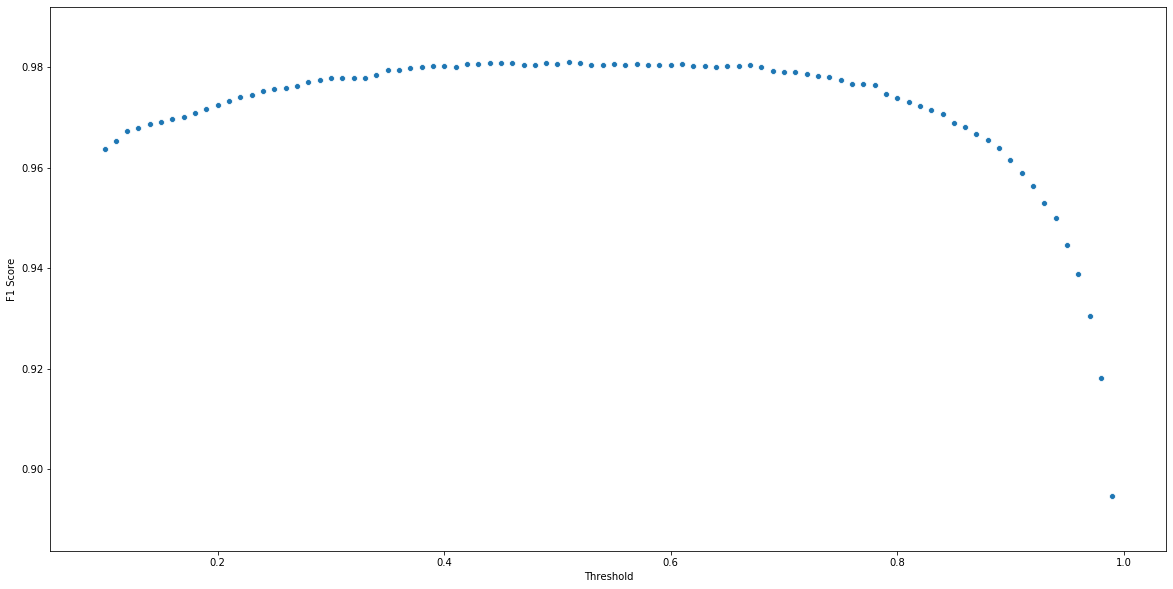

In [13]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.scatterplot(np.arange(0.1, 1, 0.01),f1_score)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')